In [1]:
## code reference: https://github.com/hanson-hschang/Reservoir-Observer/blob/master/ReservoirObserver.py

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [3]:
class Reservoir(object):
    def __init__(self, dt, n, m, d=400, alpha=1., beta=1e-10, D=20, rho=1., w=1.):
        '''
        d: # of reservoir node. default 400
        alpha: leakage rate. default 1 
        beta: ridge regression parameter, a very small numnber. Default 1e-10
        D: average degree. default 20
        rho: spectral radius. default 1
        w:
        '''
        
        # parameter definition
        self.dt = dt
        self.alpha = alpha
        self.beta = beta
        self.d = d
        self.n = n
        self.m = m
        
        ## input layer
        self.W_in = np.zeros([self.d, self.n])
        self.b_in = np.ones(self.d)
        
        self.A = np.zeros([self.d, self.d])
        
        ## output layer
        self.W_out = np.zeros([self.m, self.d])
        self.b_out = np.zeros(self.m)

        self.D = D
        self.rho = rho
        self.w = w 

        self.U_mean = np.zeros(self.n)
        self.U_variance = np.zeros(self.n)
        self.r = np.zeros(self.d)
        self.Y_mean = np.zeros(self.m)
        self.Y_variance = np.zeros(self.m)

        probability = self.D/self.d
        for di in range(self.d):
            for dj in range(di, self.d):
                if np.random.rand()<probability:
                    self.A[di,dj] = np.random.uniform(-1,1)
                    self.A[dj,di] = self.A[di,dj]
        eigenvalues, _ = np.linalg.eig(self.A)
        self.A = self.A/np.abs(np.max(eigenvalues))*self.rho
        for n, d in enumerate(np.random.choice(self.n, self.d)):
            self.W_in[n,d] = np.random.uniform(-self.w, self.w)
    
    ## equation (1)
    def reservoir_dynamics(self, r, U):  
        ## w_in*u+b is the input layer
        return (1-self.alpha)*r + self.alpha*np.tanh(np.matmul(self.A,r) + np.matmul(self.W_in,U) + self.b_in)

    def train(self, U, Y, show_time=False):
        ## u, y: input and actual output
        self.U_mean = np.reshape(np.mean(U, axis=1), [-1,1])
        self.U_variance = np.reshape(np.var(U, axis=1), [-1,1])
        self.Y_mean = np.reshape(np.mean(Y, axis=1), [-1,1])
        self.Y_variance = np.reshape(np.var(Y, axis=1), [-1,1])
        
        ## in this paper, process all u(t) and s(t)  (U and Y)
        ## so that they have zero mean and unit variance
        normalized_U = (U-self.U_mean)/self.U_variance
        normalized_Y = (Y-self.Y_mean)/self.Y_variance

        r = np.zeros([self.d, Y.shape[1]])
        
        ## {r1, r2,...rT}
        for k in range(Y.shape[1]):
            if show_time and np.mod(k,int(1/self.dt))==0:
                print("===========time: {} [s]==============".format(int(k*self.dt)))
            if not k==(Y.shape[1]-1):
                r[:,k+1] = self.reservoir_dynamics(r[:,k], normalized_U[:,k])

        r_mean = np.reshape(np.mean(r, axis=1), [-1,1])
        diff_r = r-r_mean
        Y_mean = np.reshape(np.mean(normalized_Y, axis=1), [-1,1])
        diff_Y = normalized_Y - Y_mean
        numerator =  np.einsum('mk,kn->mn',diff_Y, np.transpose(diff_r))
        denominator = np.einsum('ik,kj->ij',diff_r, np.transpose(diff_r))+self.beta*np.identity(self.d)
        
        ## calculation in the output layer
        self.W_out = np.matmul(numerator,np.linalg.inv(denominator))
        self.b_out = -np.reshape(np.matmul(self.W_out,r_mean)-Y_mean, [-1])
        
        # rt
        self.r = r[:,-1]
        self.U_mean = np.reshape(self.U_mean, [-1])
        self.U_variance = np.reshape(self.U_variance, [-1])
        return 
    
    def predict(self, U):
        ## output W_out * r + c
        Y = np.reshape(np.matmul(self.W_out, self.r)+self.b_out, [-1,1])
        normalized_U = np.reshape(np.squeeze((U-self.U_mean)/self.U_variance), [-1])
        self.r = self.reservoir_dynamics(self.r, normalized_U)
        return np.reshape(Y*self.Y_variance+self.Y_mean, [-1])
    
    def run(self, U, show_time=False):
        Y_hat = np.zeros([self.m, U.shape[1]])
        for k in range(U.shape[1]):
            if show_time and np.mod(k,int(1/self.dt))==0:
                print("===========time: {} [s]==============".format(int(k*self.dt)))
            Y_hat[:,k] = self.predict(U[:,k])
        return Y_hat

In [4]:
class Signal(object):
    """Signal:
        Notation Notes:
            Nd: dimension of states(X)
            M: number of observations(Y)
        Initialize = Signal(signal_type, T)
            signal_type: signal class
            T: float or int, end time in sec
        Members =
            dt: float, size of time step in sec
            T: float, end time in sec, which is also an integer mutiple of dt
            t: numpy array with the shape of (T/dt+1,), i.e. 0, dt, 2dt, ... , T-dt, T
            f(X, t): state tansition function maps states(X) to states(X_dot)
            h(X): observation function maps states(X) to observations(Y)
            X: numpy array with the shape of (Nd,T/dt+1), states in time series
            Y: numpy array with the shape of (M,T/dt+1), observations in time series
    """
    def __init__(self, signal_type, T):
        self.dt = signal_type.dt
        self.T = self.dt*int(T/self.dt)
        self.t = np.arange(0, self.T+self.dt, self.dt)

        self.f = signal_type.f
        self.h = signal_type.h
        
        self.X = np.transpose(odeint(func=self.f, y0=signal_type.X0, t=self.t))
        self.Y = np.reshape(self.h(self.X), [-1, self.t.shape[0]])

## Rossler System

In [5]:
class Rossler(object):
    def __init__(self, dt=0.1, X0=[0.,0.,0.], a1=0.5, a2=2., a3=4.):
        '''
        in this paper, authors set a=0.5, b = 2, and c = 4, which corresponds to a1, a2,and a3, respectively.
        X0[0]: x
        X0[1]: y
        X0[2]: z
        '''
        self.sigma_B = [0,0,0]
        self.sigma_W = [0]
        self.X0 = X0
        self.dt = dt
        self.a1 = a1
        self.a2 = a2
        self.a3 = a3
    
    def f(self, X, t):
        '''
        dx/dt = -y-z
        dy/dt = x + ay
        dz/dt = b + z(x-c)
        where X0[0], x0[1], and X0[2] represent x, y, and z, respectively,
        and a1,a2,and a3 represent a, b, and c, respectively.
        '''
        X_dot = np.zeros(len(self.sigma_B))
        X_dot[0] = -X[1] - X[2]
        X_dot[1] =  X[0] + self.a1*X[1]
        X_dot[2] =  self.a2 + X[2]*(X[0]-self.a3)
        return X_dot
    
    def h(self, X):
        return X[0]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ValueError: keyword fontsize is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

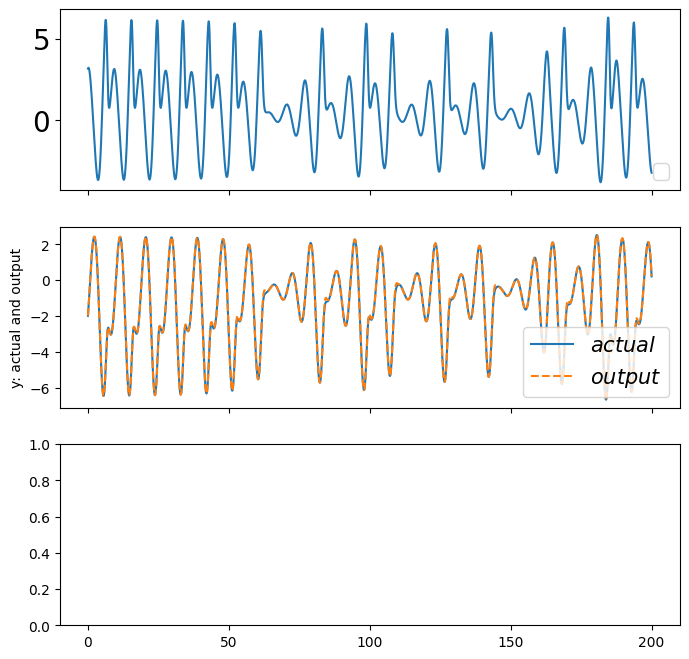

In [6]:

'''Time Setting'''
T = 20
fs = 20
dt = 1/fs

'''Training Signal Setting'''
## define signal type: rossler
signal_type = Rossler(dt=dt, X0=[0.,0.,0.])
signal = Signal(signal_type=signal_type, T=T)

observer = Reservoir(dt=signal.dt, n=signal.Y.shape[0], m=signal.X.shape[0], alpha=0.2, beta=1e-8)
observer.train(signal.Y, signal.X, show_time=False)

'''Testing Signal Setting'''
signal_type = Rossler(dt=dt, X0=signal.X[:,-1])
# signal_type = Rossler(dt=dt, X0=np.random.uniform(-1,1,3))
signal = Signal(signal_type=signal_type, T=10*T)
X_hat = observer.run(signal.Y, show_time=False)

# plot setting
fontsize = 20
fig, axes = plt.subplots(3,1,figsize=(8,8), sharex=True)
axes[0].plot(signal.t, signal.X[0])
# axes[0].plot(signal.t, X_hat[0], label=r'$y_0$',linestyle='dashed')
axes[0].legend(fontsize=fontsize-5, loc='lower right')
axes[0].tick_params(labelsize=fontsize)

axes[1].plot(signal.t, signal.X[1], label=r'$actual$')
axes[1].plot(signal.t, X_hat[1], label=r'$output$', linestyle='dashed')
axes[1].legend(fontsize=fontsize-5, loc='lower right')
axes[1].set_ylabel('y: actual and output')
axes[1].tick_params(labelsize=fontsize, fontsize=fontsize-5)

axes[2].plot(signal.t, signal.X[2], label=r'$actual$')
axes[2].plot(signal.t, X_hat[2], label=r'$output$', linestyle='dashed')
axes[2].legend(fontsize=fontsize-5, loc='lower right')
axes[2].set_ylabel('z: actual and output', fontsize=fontsize-5)
axes[2].tick_params(labelsize=fontsize)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('\ntime $t$ [s]', fontsize=fontsize)
plt.show()
pass

In [ ]:
signal.Y.shape, signal.X.shape, X_hat.shape

## Lorenz System

In [ ]:
class Lorenz(object):
    def __init__(self, dt=0.05, X0=[1.,1.,1.], a1=10., a2=28., a3=8/3):
        '''
        in this paper, authors set a=10, b = 28, and c = 8/3, which corresponds to a1, a2,and a3, respectively.
        X0[0]: x
        X0[1]: y
        X0[2]: z
        '''
        self.sigma_B = [0,0,0]
        self.sigma_W = [0]
        self.X0 = X0
        self.dt = dt
        self.a1 = a1
        self.a2 = a2
        self.a3 = a3
    
    def f(self, X, t):
        '''
        dx/dt=−ax+ay,
        dy/dt=bx−y−xz,
        dz/dt=cz+xy,
        '''
        X_dot = np.zeros(len(self.sigma_B))
        
        ## original code is -self.a1*X[0] + self.a2*X[1]
        ## but in the paper, the equation is -ax+ay
        ## not sure, but I changed it
        X_dot[0] = -self.a1*X[0] + self.a1*X[1]
        X_dot[1] =  self.a2*X[0] - X[1] - X[0]*X[2]
        X_dot[2] =  -self.a3*X[2] + X[0]*X[1]
        return X_dot
    
    def h(self, X):
        return X[0]

In [ ]:

'''Time Setting'''
T = 20
fs = 20
dt = 1/fs

'''Training Signal Setting'''
signal_type = Lorenz(dt=dt, X0=[1.,1.,1.])
signal = Signal(signal_type=signal_type, T=T)
observer = Reservoir(dt=signal.dt, n=signal.Y.shape[0], m=signal.X.shape[0], alpha=0.2, beta=1e-8)
observer.train(signal.Y, signal.X, show_time=False)

'''Testing Signal Setting'''
signal_type = Lorenz(dt=dt, X0=signal.X[:,-1])
signal = Signal(signal_type=signal_type, T=T)
X_hat = observer.run(signal.Y, show_time=False)


## plot setting
fontsize = 20
fig, axes = plt.subplots(3,1,figsize=(8,8), sharex=True)
axes[0].plot(signal.t, signal.X[0])
# axes[0].legend(fontsize=fontsize-5, loc='lower right')
axes[0].tick_params(labelsize=fontsize)

axes[1].plot(signal.t, signal.X[1], label=r'$actual$')
axes[1].plot(signal.t, X_hat[1], label=r'$output$', linestyle='dashed')
axes[1].legend(fontsize=fontsize-5, loc='lower right')
axes[1].set_ylabel('y: actual and output',fontsize=fontsize-5)
axes[1].tick_params(labelsize=fontsize)

axes[2].plot(signal.t, signal.X[2], label=r'$actual$')
axes[2].plot(signal.t, X_hat[2], label=r'$output$', linestyle='dashed')
axes[2].legend(fontsize=fontsize-5, loc='lower right')
axes[2].set_ylabel('z: actual and output',fontsize=fontsize-5)
axes[2].tick_params(labelsize=fontsize)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('\ntime $t$ [s]', fontsize=fontsize)
plt.show()
pass
